<h1>Convolutional Neural Networks on CIFAR10 Dataset</h1>
<hr>

In [1]:
# importing data libraries.
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 100
transformation_train = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
 

transformation_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# importing dataset
train_dataset = datasets.CIFAR10(root='./root', train=True,  download=True, transform=transformation_train)
test_dataset  = datasets.CIFAR10(root='./root', train=False, download=True, transform=transformation_test)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

# constructing data loaders.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_iterator = iter(train_loader)
train_images, train_labels = train_iterator.next()
print( train_images.shape )
print( train_labels.shape )

torch.Size([100, 3, 32, 32])
torch.Size([100])


In [5]:
# plots an image.
def convert_img(tensor_image):
    np_image = tensor_image.clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalising image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image

# plots an image.
def convert_img_cuda(tensor_image):
    np_image = tensor_image.cpu().clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalising image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image

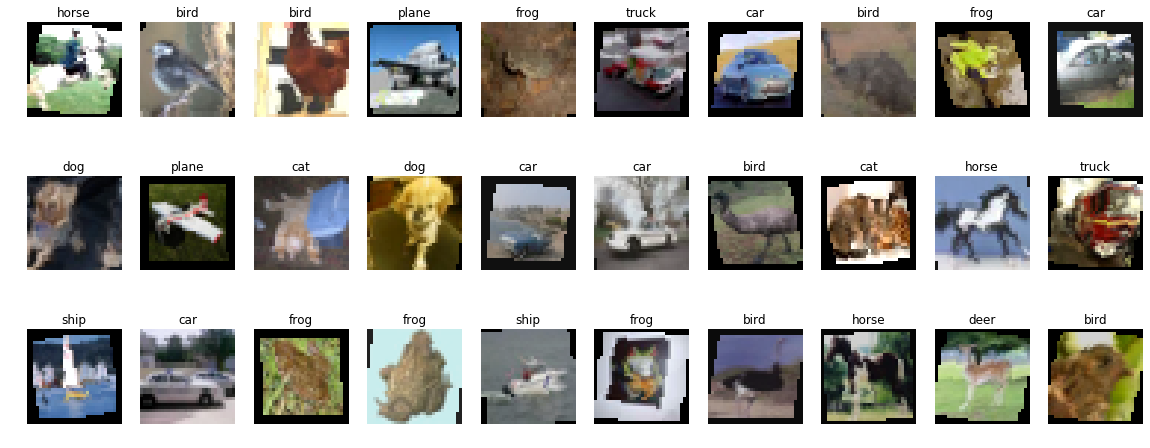

In [6]:
figure = plt.figure(figsize=(20,8))    

for i in range(30):
    axes = figure.add_subplot(3, 10, i+1)
    image = convert_img(train_images[i])
    title = classes[ train_labels[i] ]
    plt.imshow(image) 
    plt.title(title)
    plt.axis('off')

plt.show()

In [7]:
channel_input = 3
conv1_depth = 16
conv2_depth = 32
conv3_depth = 64
filter1 = 3
filter2 = 3
filter3 = 3
stride1 = 1
stride2 = 1
stride3 = 1
max_pool_kernel1 = 2
max_pool_kernel2 = 2
max_pool_kernel3 = 2
input_size = 4 * 4 * 64
hidden_size = 500
output_size = 10

# building model with two hidden layers.
class LeNet(nn.Module):
  
    # constructor
    def __init__(self):
        super().__init__()
        self.convolution1 = nn.Conv2d(channel_input, conv1_depth, filter1, stride1, padding=1) 
        self.convolution2 = nn.Conv2d(conv1_depth,   conv2_depth, filter2, stride2, padding=1) 
        self.convolution3 = nn.Conv2d(conv2_depth,   conv3_depth, filter3, stride3, padding=1) 
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(hidden_size, output_size)
  
    # 2 hidden with relu activation
    def propagate_forward(self, x):
        x = self.convolution1(x)
        x = F.max_pool2d(x, max_pool_kernel1, max_pool_kernel1)
    
        x = self.convolution2(x)
        x = F.max_pool2d(x, max_pool_kernel2, max_pool_kernel2)
    
        x = self.convolution3(x)
        x = F.max_pool2d(x, max_pool_kernel3, max_pool_kernel3)
    
        x = x.view(-1, input_size)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        return x

In [8]:
lenet_model = LeNet().to(device)
lenet_model

LeNet(
  (convolution1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convolution3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (linear2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(lenet_model.parameters(), lr = 0.001)

In [10]:
numOfEpochs = 15
train_count = len(train_loader) * batch_size
test_count  = len(test_loader)  * batch_size
train_losses = []
test_losses  = []
train_acurracies = []
test_acurracies  = []

# training with the number of epochs.
for epoch in range(numOfEpochs):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
  
    # training the model with the train dataset.
    for train_images, train_labels in train_loader:
    
        # registering train images and labels 
        # to device to benefit from GPU
        train_images = train_images.to( device )
        train_labels = train_labels.to( device )
    
        # calculating loss for training
        # dataset for the current batch.
        train_labels_head = lenet_model.propagate_forward(train_images) 
        loss = criterion(train_labels_head, train_labels)
    
        # updating weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    
        # calculating acurracy for the current
        # batch for the training dataset.
        predictions = torch.max( train_labels_head , 1)[1] 
        acurracy = torch.sum( predictions == train_labels )
    
        # summing training acurracy and 
        # loss wit the remaining batches.
        train_acc += acurracy 
        train_loss += loss.item()
    
    print("EPOCH --> " + str(epoch + 1))
    print("----------------------------------------------")
  
    # testing the current model within the current epoch.
    for test_images, test_labels in test_loader:
    
        # registering test images and labels 
        # to device to benefit from GPU
        test_images = test_images.to( device )
        test_labels = test_labels.to( device )
    
        # calculating loss for test 
        # dataset for the current batch.
        test_labels_head = lenet_model.propagate_forward(test_images)
        loss = criterion(test_labels_head, test_labels)
    
        # calculating acurracy for the cur-
        # rent batch for the test dataset.
        predictions = torch.max( test_labels_head , 1)[1] 
        acurracy = torch.sum( predictions == test_labels )
    
        # summing test acurracy and 
        # loss wit the remaining batches.
        test_acc += acurracy 
        test_loss += loss.item()
 
    # printing out the training dataset 
    # results for the current batch.
    train_acc = float(train_acc.float()) / train_count
    train_acurracies.append( train_acc )
    print("Train Acurracy: " + str( float(train_acc) ))
    
    train_loss = train_loss / train_count
    train_losses.append( train_loss )
    print("Train Loss: " + str(train_loss) + "\n")
  
    # printing out the test dataset 
    # results for the current batch.
    test_acc = float(test_acc.float()) / test_count
    test_acurracies.append( test_acc )
    print("Test Acurracy: " + str( float(test_acc) ))    
    
    test_loss = test_loss / test_count
    test_losses.append( test_loss )
    print("Test Loss: " + str(test_loss))
    print("----------------------------------------------\n")

EPOCH --> 1
----------------------------------------------
Train Acurracy: 0.43154
Train Loss: 0.015808140947818756

Test Acurracy: 0.5495
Test Loss: 0.012663337993621826
----------------------------------------------

EPOCH --> 2
----------------------------------------------
Train Acurracy: 0.55382
Train Loss: 0.012674363794326782

Test Acurracy: 0.6027
Test Loss: 0.011188848632574081
----------------------------------------------

EPOCH --> 3
----------------------------------------------
Train Acurracy: 0.59372
Train Loss: 0.011534220843315124

Test Acurracy: 0.6482
Test Loss: 0.010117778444290161
----------------------------------------------

EPOCH --> 4
----------------------------------------------
Train Acurracy: 0.61912
Train Loss: 0.010828987445831299

Test Acurracy: 0.6619
Test Loss: 0.009632439255714416
----------------------------------------------

EPOCH --> 5
----------------------------------------------
Train Acurracy: 0.63832
Train Loss: 0.01034737897515297

Test Acu

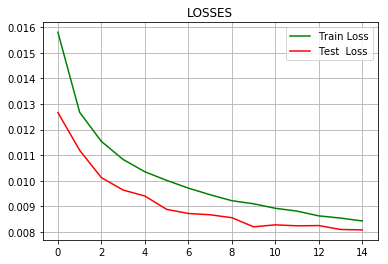

In [11]:
# plotting loss graph.
plt.title("LOSSES")
plt.plot(train_losses, label = "Train Loss", color= "green")
plt.plot(test_losses,  label = "Test  Loss", color= "red")
plt.legend()
plt.grid()

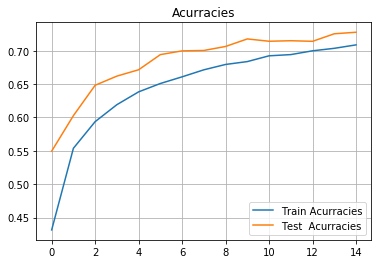

In [12]:
plt.title("Acurracies")
plt.plot(train_acurracies, label = "Train Acurracies")
plt.plot(test_acurracies,  label = "Test  Acurracies")
plt.legend()
plt.grid()

In [13]:
test_iterator = iter(test_loader)
test_images, test_labels = test_iterator.next()
test_labels = test_labels.to( device )
test_images = test_images.to( device )
test_predict = lenet_model.propagate_forward(test_images)
test_predict = torch.max( test_predict , 1)[1] 
print( test_images.shape )
print( test_labels.shape )
print( test_predict.shape )

torch.Size([100, 3, 32, 32])
torch.Size([100])
torch.Size([100])


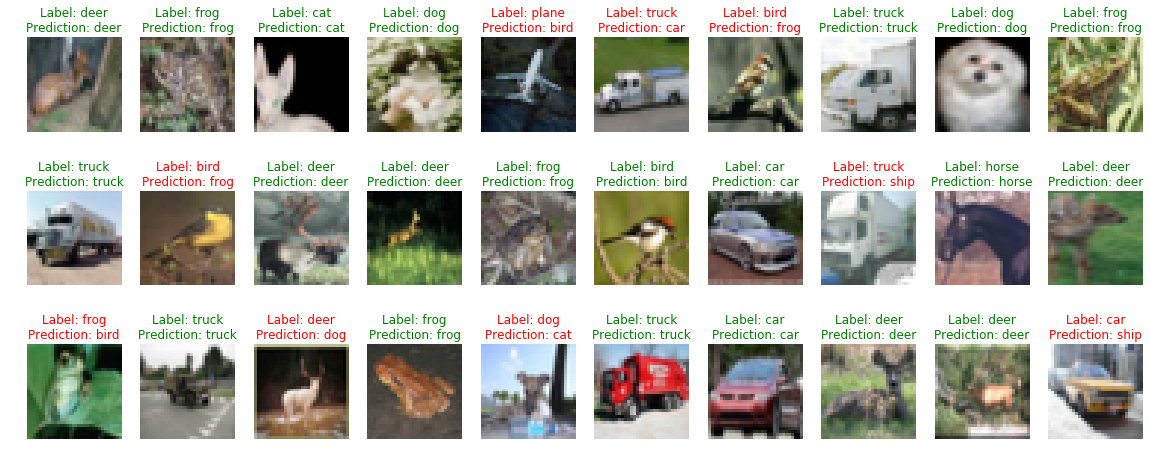

In [14]:
figure = plt.figure(figsize=(20,8))    

for i in range(30):
    axes = figure.add_subplot(3, 10, i+1)
    image = convert_img_cuda(test_images[i])
    title = "Label: " + str( classes[ test_labels[i] ] ) + "\n" + "Prediction: " + str(classes[ test_predict[i] ]) 
    plt.imshow(image) 
    plt.axis('off')
    
    if( str( classes[ test_labels[i] ] ) == str(classes[ test_predict[i] ] )):
        plt.title(title, color="green")
    else:
        plt.title(title, color="red")

plt.show()

In [17]:
acurracy = torch.sum( test_predict == test_labels )
print( "Acurracy: " + str(float(acurracy)))

Acurracy: 74.0
